# Preliminary loading and photon noise calculation for LIM 

The calculation is done in a very similar style as I usually do for CMB/BICEP. Radiation from a single element can be generalized as

$$Q = \int^{\nu_{max}}_{\nu_{min}} \rm{d}\nu \int \rm{d}A \int \rm{d}\Omega\eta \epsilon B_\nu(T)$$

$B_\nu(T)$ is the spectral radiance density of a blackbody at $T$. The source brightness temperature can be frequency dependent in certain cases, eg. the atmosphere as shown below. $\epsilon$ is a generalized emissivity, eg. transmission of the atmosphere will be included in $\epsilon$ when calculating CMB loading. $\eta$ is the optical efficiency of the system. $\epsilon$ and $\eta$ can also be frequency dependent. $A$ and $\Omega$ are detector sensive area and the input solid angle. For our telescopes we usually have the integrated $A\Omega = \lambda^2$ for optimized spillover efficiency. 

Below I'm showing atmosphere temperature and transmission at South Pole. There are four main windows we use for observations: <50 GHz, ~100 GHz, ~150 GHz, and 180-300 GHz. The higher the frequency, the worse the atmosphere loading. So 270/300 GHz is probably the highest we can go for ground observations. Going to space can solve the atmosphere problem, but you will have other things to worry about, like, money.

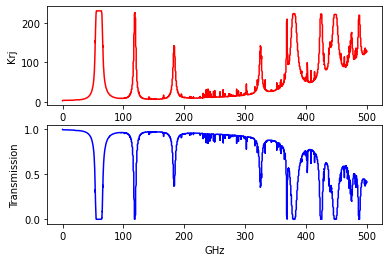

In [1]:
import numpy as np
from astropy import units as u
from astropy import constants as const
from astropy.modeling import models
import matplotlib.pyplot as plt

atmos=np.loadtxt('/Users/bicep/Documents/DeviceDesign/atmosspec.txt')
f=atmos[:,0]*u.GHz
T=atmos[:,1]
Trj=atmos[:,2]*u.K

space=False
if space:
    T=np.full_like(T,1)
    Trj=np.full_like(T,0)*u.K


fig,ax = plt.subplots(2,1)

ax[0].plot(f,Trj,color='red')
ax[0].set_ylabel('Krj')

ax[1].plot(f,T,color='b')
ax[1].set_xlabel('GHz')
ax[1].set_ylabel('Transmission')

plt.show()

## bandpass (R) and optical efficiency
The current SLIM design is targeting $R=300$. I assign a bandwidth of $\nu/R$ for each frequency. For the highest band we consider here, at 300 GHz, the bandwidth is just 1 GHz. So I'll simplify the integration with $\int S(\nu) d\nu = S(\bar{\nu})\Delta\nu$.

The optical efficiency is assumed to be 20% or 40%. Kirit said 40% is a bit optimistic for now, but it will be where we want to be in the future.  

In [2]:
R=300
bw=f/R
lw=(const.c/f).to('mm')
AO=lw**2*u.sr
oe=0.4


/Users/bicep/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## Q atmosphere
The atmosphere temperature (usually >10K) is high relative to the frequency range we are interested in (the Wien's law!). So we can use the Rayleign-Jeans approximation. The nice thing about Rayleign-Jeans is it has that $\nu^2/c^2$, which got cancelled out with the $A\Omega$. An $1/sin$ factor is added in to consider the increase of airmass at certain elevation pointings.

The loading here is for a single polarization.

In [3]:
# atmosphere
Qatm=(oe*const.k_B*Trj*bw/np.sin(np.radians(50))).to('pW')

## Q CMB

The uniform CMB radiation at 2.73 K is the brightest source outside atmosphere in our bandpass. The atmosphere transmission adds in a small angle dependent effect in calculating the CMB. 

The line intensity is a bit harder to consider comparing to CMB. And basing on reference materials, the lines should not over dominate CMB. I'm ignoring it from the total loading for now.

The loading here is for a single polarization.

10.3847/1538-4357/ac3edd Figure 4.

In [4]:
# cmb
Tcmb=2.73*u.K
bbcmb= models.BlackBody(temperature=Tcmb)
Qcmb = (0.5*oe*AO*bbcmb(f)*bw*(1-(1-T)/np.sin(np.radians(50)))).to('pW')

/Users/bicep/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## Q instrument

Instrument loading is the easiest to calculate but probably the hardest to get it right. I assuming a stack of optics at 220K, 50K, 4K, each with a .01 emissivity. 

If things are in space, we will not have the 220K layer for sure. I'm not sure about 50K. SphereX has a 50K layer (so they need to heat things up from 3K...). It will depend on specific design.

The loading here is for a single polarization.

In [5]:
# instrument
Tinst4=4*u.K
Tinst50=50*u.K
Tinst220=220*u.K
e=0.01
Qinst4=(oe*e*const.k_B*Tinst4*bw).to('pW')
Qinst50=(oe*e*const.k_B*Tinst50*bw).to('pW')
Qinst220=(oe*e*const.k_B*Tinst220*bw).to('pW')

## Total loading and plots

Below I plotted out the total loading of each R=300 channel. Atmosphere dominates over all others. Optics are the second significant term, though in reality it may go higher than the ideal case. Assuming a 2K line, I put down the reference of it's loading in the plot, but didn't include it in Qtot. 

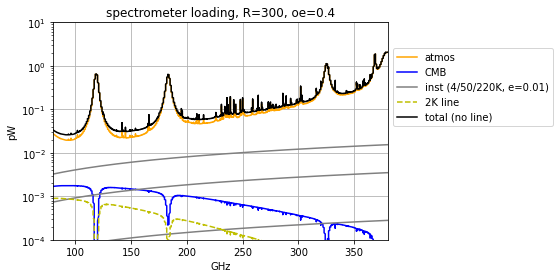

In [6]:
# 1Krj line
Tline=2*u.K
bbline= models.BlackBody(temperature=Tline)
Qline = (0.5*oe*AO*bbline(f)*bw*(1-(1-T)/np.sin(np.radians(50)))).to('pW')

if not space:
    plt.plot(f,Qatm,color='orange',label='atmos')
plt.plot(f,Qcmb,color='b',label='CMB')
plt.plot(f,Qinst4,color='grey',label='inst (4/50/220K, e=0.01)')
plt.plot(f,Qinst50,color='grey')
if not space:
    plt.plot(f,Qinst220,color='grey')
plt.plot(f,Qline,color='y',linestyle='--', label='2K line')
if space:
    Qtot=Qcmb+(Qinst4+Qinst50)
else:
    Qtot=Qatm+Qcmb+(Qinst4+Qinst50+Qinst220)
Qtotp=Qtot+Qline
plt.plot(f,Qtot,color='k',linestyle='-',label='total (no line)')
#plt.plot(f,Qtotp,color='k',linestyle='--',label='')
plt.xlim(80,380)
plt.ylim(1e-4,10)
plt.xlabel('GHz')
plt.ylabel('pW')
plt.title('spectrometer loading, R=%d, oe=%.1f'%(R,oe))
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.yscale('log')

X = np.vstack((f.value,bw.value,Qatm.value,Qcmb.value,Qinst4.value,Qinst50.value,Qinst220.value,Qline.value,Qtot.value,Qtotp.value)).T
if space:
    np.savetxt('/Users/bicep/Documents/DeviceDesign/MKID_SNF/slim_r%d_oe%.1f_spaceloading.txt'%(R,oe),X)
else:
    np.savetxt('/Users/bicep/Documents/DeviceDesign/MKID_SNF/slim_r%d_oe%.1f_loading.txt'%(R,oe),X)

## NEP

The noise equivalent power of photon noise is

$$NEP_{photon} = 2Qh\nu + Q^2/\Delta \nu$$

The first term is shot noise and the second is the bose/wave noise.



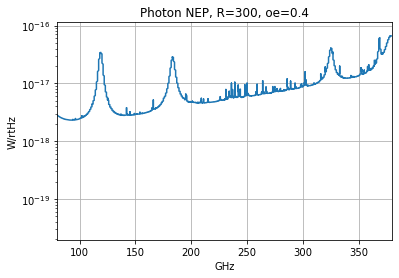

In [7]:
def get_NEPphoton2(f,bw,Q):
    nep2 = 2*Q*const.h*f + Q**2/bw
    return nep2

nep_ph2 = (get_NEPphoton2(f,bw,Qtot)).to(' W^2/Hz')
nep=nep_ph2**0.5
plt.plot(f,nep)
plt.xlim(80,380)
plt.yscale('log')

plt.xlabel('GHz')
plt.ylabel('W/rtHz')
plt.title('Photon NEP, R=%d, oe=%.1f'%(R,oe))
plt.grid()
plt.yscale('log')